In [15]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# Read in Data


In [2]:
#read in processed data 
train = pd.read_csv('..\\data\\processed\\trainset.csv')
test = pd.read_csv('..\\data\\processed\\testset.csv')
train.head()

,OutcomeType,gender,hasName,ageWeeks,isDog,isMix,month,weekday,hourOfDay,isFixed,newBreed,newColor
0,Return_to_owner,Male,1,52.0,1,1,2,Wednesday,18,1,Other,Brown/White
1,Euthanasia,Female,1,52.0,0,1,10,Sunday,12,1,Domestic Shorthair Mix,Other
2,Adoption,Male,1,104.0,1,1,1,Saturday,12,1,Pit Bull Mix,Blue/White
3,Transfer,Male,0,3.0,0,1,7,Friday,19,0,Domestic Shorthair Mix,Other
4,Transfer,Male,0,104.0,1,0,11,Friday,12,1,Other,Tan


# Transform Data

In [3]:
categorical = ['gender', 'hasName', 'isDog', 'isMix', 'month', 'weekday', 'hourOfDay', 'isFixed', 'newBreed', 'newColor']    

# Convert data type as 'category'
train_binary = train.copy()
test_binary = test.copy()
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')
    test_binary[i] = test_binary[i].astype('category')
    
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
test_binary_dummy = pd.get_dummies(test_binary, columns = categorical)
test_binary_dummy.drop('OutcomeType', axis=1, inplace=True)
train_binary_dummy.head()

,OutcomeType,ageWeeks,gender_Female,gender_Male,gender_Unknown,hasName_0,hasName_1,isDog_0,isDog_1,isMix_0,...,newColor_Red/White,newColor_Tan,newColor_Tan/White,newColor_Torbie,newColor_Tortie,newColor_Tricolor,newColor_White,newColor_White/Black,newColor_White/Brown,newColor_White/Tan
0,Return_to_owner,52.0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Euthanasia,52.0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adoption,104.0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Transfer,3.0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Transfer,104.0,0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [4]:
train_binary_dummy.shape
test_binary_dummy.shape

(11456, 113)

# Fit Random Forest

In [5]:
def fit_randomforest(x_train, y_train, max_features="auto"):
    num_trees = 250
    SEED = 12345
    model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=SEED)
    model.fit(x_train, y_train)
    
    return model

In [6]:
# train
y_train = train_binary_dummy['OutcomeType']
x_train = train_binary_dummy.drop('OutcomeType', axis=1)
model_rf = fit_randomforest(x_train, y_train)


In [7]:
print(x_train.columns.shape)
type(x_train.columns)

(113,)


pandas.core.indexes.base.Index

In [8]:
type(model_rf)

sklearn.ensemble.forest.RandomForestClassifier

# Feature Importance

In [20]:
feature_importances = pd.DataFrame(model_rf.feature_importances_,index = x_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(15)

,importance
ageWeeks,0.151881
isFixed_1,0.064751
isFixed_0,0.060198
hasName_0,0.024850
hasName_1,0.024491
newColor_Other,0.018846
hourOfDay_17,0.014543
month_12,0.014432
month_10,0.014098
hourOfDay_18,0.013867


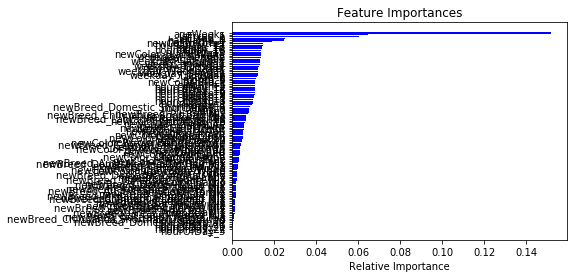

In [17]:
features = x_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Test Model

In [32]:
# test
predicted = pd.DataFrame(model_rf.predict_proba(test_binary_dummy))
predicted.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
predicted.reset_index()
predicted.index += 1
predicted.index.name = 'ID'
print(predicted.head())

predicted.to_csv('submission.csv')

    Adoption  Died  Euthanasia  Return_to_owner  Transfer
ID                                                       
1      0.016   0.0       0.076            0.212     0.696
2      0.696   0.0       0.000            0.116     0.188
3      0.112   0.0       0.008            0.644     0.236
4      0.208   0.0       0.048            0.204     0.540
5      0.382   0.0       0.000            0.562     0.056


In [33]:
predicted.shape

(11456, 5)